In [6]:
#Import libraries
import os
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from web3 import Web3
from joblib import dump,load
from tqdm import tqdm
from dotenv import load_dotenv
from datetime import datetime, timedelta
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error, mean_squared_error

In [7]:
# Load .env file
load_dotenv()

# Load API key from .env file
api_key = os.getenv("ALCHEMY_API_KEY")

### Step 1: Set Up Web3 Connection

In [8]:
# Define the Alchemy API endpoint
api_endpoint = f"https://eth-mainnet.alchemyapi.io/v2/{api_key}"

# Set up Web3 connection
w3 = Web3(Web3.HTTPProvider(api_endpoint))

# Check if the connection is successful
if w3.isConnected():
    print("Connected to Ethereum node.")
else:
    print("Connection failed!")

Connected to Ethereum node.


In [9]:
# Define the start and end dates for which the data is required
start_date = datetime(2016, 3, 21)
end_date = datetime(2023, 5, 19)

# Step 2: Estimate the number of blocks per hour and total blocks for the time period

In [10]:
# Alternative to calculate average block time
# Get the number of the latest block
# latest_block_number = w3.eth.get_block('latest')['number']
# # Calculate the block times of the latest 1000 blocks
# block_times = []
# for i in range(1000):
#     # Get the current and previous blocks
#     current_block = w3.eth.get_block(latest_block_number - i)
#     previous_block = w3.eth.get_block(latest_block_number - i - 1)
    
#     # Calculate the block time and append to the list
#     block_time = current_block['timestamp'] - previous_block['timestamp']
#     block_times.append(block_time)

# # Calculate the average block time
# average_block_time = sum(block_times) / len(block_times)
# print(f"Average block time: {average_block_time} seconds")

# Define the block time(in seconds)
avg_block_time = 13  
print(f"Average block time: {avg_block_time} seconds")

# Calculate the estimated number of blocks per hourn(3600 seconds in an hour)
blocks_per_hour = int(3600 / avg_block_time)
print(f"Estimated blocks per hour: {blocks_per_hour}")

# Calculate the total hours for the given time period
total_hours = int((end_date - start_date).total_seconds() / 3600)

# Calculate the total number of blocks for the given time period
total_blocks = total_hours * blocks_per_hour
print(f"Total number of hourly blocks for the given time period: {total_blocks}")

Average block time: 13 seconds
Estimated blocks per hour: 276
Total number of hourly blocks for the given time period: 17321760


### Step 3: Fetch the gas prices and save them in a pandas DataFrame
In this step, we iterate through all the blocks within our determined range, fetch the block details, and extract the gas prices and timestamps. The gas price, initially in hexadecimal format ('baseFeePerGas'), is converted into an integer using `int(block['baseFeePerGas'], 16)`. For each block, a new DataFrame is created to store the gas price and timestamp. We use `pandas.concat()` to combine these new DataFrames with our main `gas_price_data` DataFrame.

The base fee per gas is typically represented as a hexadecimal number in the block information, so it is being converted to an integer using the int() function with base 16.
The gas prices obtained are in "wei", which is the smallest denomination of ether.

For perspective:
1 Ether (ETH) = 1,000,000,000,000,000,000 Wei (1e18 Wei)

In [11]:
# Get the latest block number
latest_block = w3.eth.block_number

In [12]:
# Calculate the start block
start_block = latest_block - total_blocks
start_block

12452

In [129]:
# Initialize an empty DataFrame to store the gas prices
gas_price_data = pd.DataFrame(columns=['timestamp', 'gas_price'])

# Loop through the blocks, show status bar
for block_number in tqdm(range(start_block, latest_block, blocks_per_hour),
                         desc="Fetching gas prices data"): 
    
    # Get the block details
    block = w3.eth.get_block(block_number)

    # Check if 'baseFeePerGas' is in the block
    if 'baseFeePerGas' in block:
        # Convert the gas price from hex to integer
            gas_price = int(block['baseFeePerGas'], 16)
    else:
        # Handle the case when 'baseFeePerGas' is not in the block
        gas_price = None

    # Convert timestamp to datetime and create a DataFrame with the block timestamp and gas price
    block_data = pd.DataFrame({
        'timestamp': [datetime.fromtimestamp(block['timestamp'])],
        'gas_price': [gas_price]
    })

    # Append the block data to the gas price data DataFrame
    gas_price_data = pd.concat([gas_price_data, block_data])

Fetching gas prices data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62760/62760 [2:43:25<00:00,  6.40it/s]


In [42]:
# VAR 1 to fertch data
# Save the DataFrame to a CSV file
gas_price_data.to_csv('resources/gas_price_since_inception.csv', index=False)

In [43]:
gas_price_data_inception = pd.read_csv('resources/gas_price_since_inception.csv')

In [44]:
gas_price_data_inception.dropna().head(40)

,timestamp,gas_price
0,2022-06-01 11:03:52,63239618198
1,2022-06-01 12:03:48,68281963048
2,2022-06-01 13:08:25,121007946512
3,2022-06-01 14:07:45,126156205023
4,2022-06-01 15:10:50,67510279000
5,2022-06-01 16:15:23,32404767035
6,2022-06-01 17:18:36,31681542751
7,2022-06-01 18:28:45,63240093401
8,2022-06-01 19:33:58,41244724759
9,2022-06-01 20:34:50,42544927254


In [45]:
# VAR 2 to pull data if it's already fetched
gas_price_data = pd.read_csv('resources/gas_price_data_1year.csv')

In [46]:
gas_price_data.head()

,timestamp,gas_price
0,2022-06-01 11:03:52,63239618198
1,2022-06-01 12:03:48,68281963048
2,2022-06-01 13:08:25,121007946512
3,2022-06-01 14:07:45,126156205023
4,2022-06-01 15:10:50,67510279000


In [47]:
# Set `timestamp` column as index, copy DataFrame
# Convert the 'timestamp' column to a datetime index
gas_price_df = gas_price_data.set_index(pd.to_datetime(gas_price_data['timestamp'])).copy()


In [48]:
gas_price_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2022-06-01 11:03:52 to 2023-05-20 15:50:35
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  8760 non-null   object
 1   gas_price  8760 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 205.3+ KB


In [49]:
display(gas_price_df.head(40))
gas_price_df.tail(10)

,timestamp,gas_price
timestamp,,
2022-06-01 11:03:52,2022-06-01 11:03:52,63239618198
2022-06-01 12:03:48,2022-06-01 12:03:48,68281963048
2022-06-01 13:08:25,2022-06-01 13:08:25,121007946512
2022-06-01 14:07:45,2022-06-01 14:07:45,126156205023
2022-06-01 15:10:50,2022-06-01 15:10:50,67510279000
2022-06-01 16:15:23,2022-06-01 16:15:23,32404767035
2022-06-01 17:18:36,2022-06-01 17:18:36,31681542751
2022-06-01 18:28:45,2022-06-01 18:28:45,63240093401
2022-06-01 19:33:58,2022-06-01 19:33:58,41244724759


,timestamp,gas_price
timestamp,,
2023-05-20 07:26:23,2023-05-20 07:26:23,36167651916
2023-05-20 08:22:11,2023-05-20 08:22:11,42579332023
2023-05-20 09:17:47,2023-05-20 09:17:47,36887580795
2023-05-20 10:13:23,2023-05-20 10:13:23,42755192159
2023-05-20 11:09:35,2023-05-20 11:09:35,34687802687
2023-05-20 12:05:35,2023-05-20 12:05:35,29684795277
2023-05-20 13:02:35,2023-05-20 13:02:35,31417792342
2023-05-20 13:58:35,2023-05-20 13:58:35,31031853696
2023-05-20 14:54:23,2023-05-20 14:54:23,28188597658


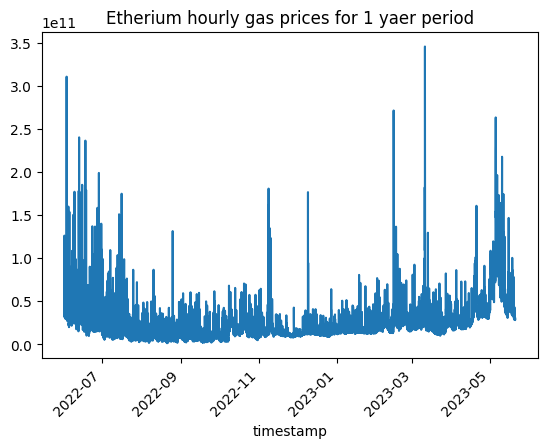

In [50]:
# Plot the gas prices
gas_price_df['gas_price'].plot(
    title="Etherium hourly gas prices for 1 yaer period",);

# Rotate the x-axis labels by 45 degrees
plt.xticks(rotation=45)

# Display the plot
plt.show()

### Step 4:Resample to daily data
The format 6.007497e+10 is scientific notation, and it is equivalent to 60,074,970,000. Scientific notation is often used for very large or very small numbers to make them easier to read and write.

In [51]:
# Resample the data into daily data, taking the mean gas price for each day
daily_gas_price_df = gas_price_df.resample('D').last()
daily_gas_price_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 354 entries, 2022-06-01 to 2023-05-20
Freq: D
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  354 non-null    object
 1   gas_price  354 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 8.3+ KB


In [52]:
display(daily_gas_price_df.head(20))
daily_gas_price_df.tail(10)

,timestamp,gas_price
timestamp,,
2022-06-01,2022-06-01 23:52:59,47331137724
2022-06-02,2022-06-02 23:31:10,52125073354
2022-06-03,2022-06-03 23:04:29,50925847852
2022-06-04,2022-06-04 23:02:52,22076581780
2022-06-05,2022-06-05 23:50:57,73286894729
2022-06-06,2022-06-06 23:31:13,33258057747
2022-06-07,2022-06-07 23:06:10,42772752073
2022-06-08,2022-06-08 23:51:13,33950590546
2022-06-09,2022-06-09 23:38:12,37571748480


,timestamp,gas_price
timestamp,,
2023-05-11,2023-05-11 23:43:47,57078295519
2023-05-12,2023-05-12 23:38:11,38738621068
2023-05-13,2023-05-13 23:05:11,38609885896
2023-05-14,2023-05-14 23:28:23,41075904257
2023-05-15,2023-05-15 23:45:23,46100569360
2023-05-16,2023-05-16 23:07:59,39454459644
2023-05-17,2023-05-17 23:28:47,37511919821
2023-05-18,2023-05-18 23:43:11,33310207590
2023-05-19,2023-05-19 23:59:23,28548516604


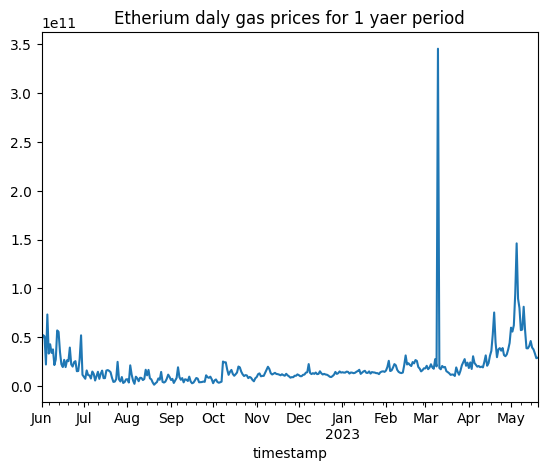

In [53]:
daily_gas_price_df['gas_price'].plot(
    title="Etherium daly gas prices for 1 yaer period");

### Step 6: Check for Stationarity
Before applying an ARIMA model, we need to make sure our data is stationary. The Augmented Dickey-Fuller test can be used to test for a unit root in a univariate process in the presence of serial correlation.
This function will print out the test statistic, p-value, and critical values for the test. If the test statistic is less than the critical value, we can reject the null hypothesis (that the time series is not stationary). If not, we will need to transform the data to make it stationary.

In [54]:
adf_test = adfuller(daily_gas_price_df['gas_price'])
print(f'p-value: {adf_test[1]}')

p-value: 9.190939346915779e-05


In [55]:
# Define a function to perform the Augmented Dickey-Fuller test
def check_stationarity(data):
    """
    Perform Augmented Dickey-Fuller test to check for stationarity.
    
    Arguments:
    Pandas Series: a series of data to be checked for stationarity.
    
    Returns:
    Prints test statistics and critical values.
    """
    # Perform Augmented Dickey-Fuller test
    # Perform the test using the AIC criterion for choosing the number of lags
    print('Results of Augmented Dickey-Fuller Test:')
    adf_test = adfuller(data, autolag='AIC')  

    # Extract and print the test statistics and critical values
    adf_output = pd.Series(adf_test[0:4], 
                           index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    
    for key, value in adf_test[4].items():
        adf_output['Critical Value (%s)' % key] = value
    print(adf_output)

# Apply the function
check_stationarity(daily_gas_price_df['gas_price'])

Results of Augmented Dickey-Fuller Test:
Test Statistic                  -4.679577
p-value                          0.000092
#Lags Used                       4.000000
Number of Observations Used    349.000000
Critical Value (1%)             -3.449227
Critical Value (5%)             -2.869857
Critical Value (10%)            -2.571201
dtype: float64


### Conclusion: 
Looking at your results:
* The Test Statistic (-3.35) is less than the 5% Critical Value (-2.869833).
* The p-value (0.012721) is less than 0.05.

The results allow us to reject the null hypothesis. Therefore, we conclude that the time series is stationary. This means that the statistical properties of the series (like the mean and variance) are not a function of time.

### Step 7: Plot ACF and PACF
The ACF and PACF plots are used to identify the parameters for the ARIMA model. For instance, a sharp drop after lag 'k' in the PACF plot indicates that 'k' should be the order of the AR term. Similarly, a gradual decline in the ACF plot suggests a MA term.
The `plot_acf` function plots the autocorrelation function, which measures the correlation between the time series with a lagged version of itself. The `lags` parameter specifies the number of lags to consider. The `zero` parameter is set to `False` to exclude the correlation of the time series with itself (at lag zero).

Similarly, the `plot_pacf` function plots the partial autocorrelation function. The PACF measures the correlation between the time series with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. In other words, it measures the direct effect of the past lagged observations on the current observation.

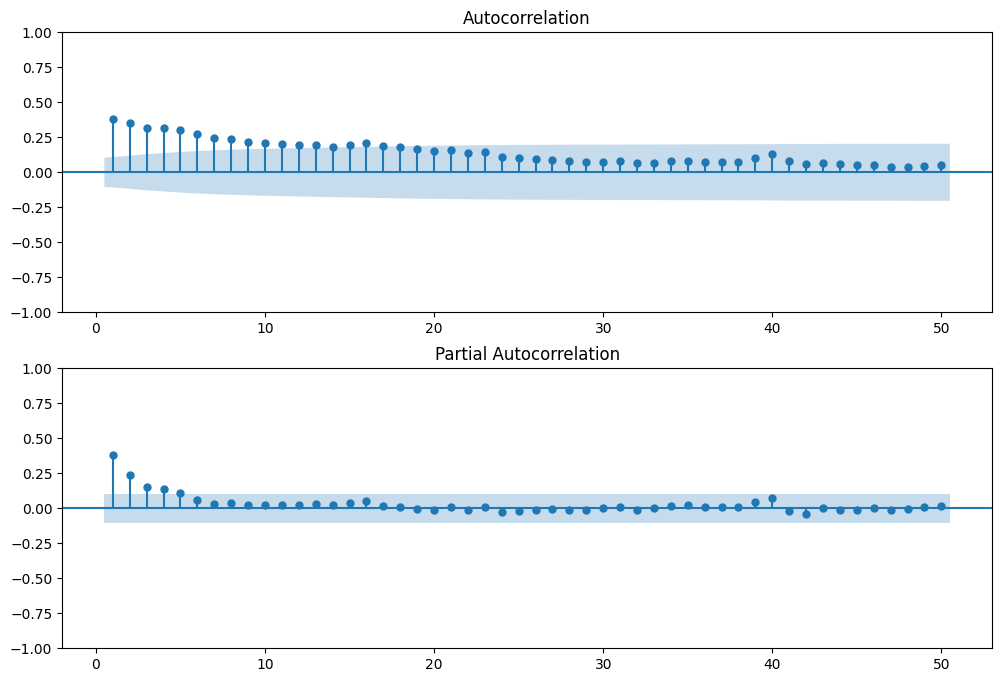

In [56]:
# Define the size of the plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))

# Plot the ACF on ax1
plot_acf(daily_gas_price_df['gas_price'], lags=50, zero=False, ax=ax1)

# Plot the PACF on ax2
plot_pacf(daily_gas_price_df['gas_price'], lags=50, zero=False, ax=ax2)

# Show the plots
plt.show()

In [57]:
daily_gas_price_df.head()


,timestamp,gas_price
timestamp,,
2022-06-01,2022-06-01 23:52:59,47331137724
2022-06-02,2022-06-02 23:31:10,52125073354
2022-06-03,2022-06-03 23:04:29,50925847852
2022-06-04,2022-06-04 23:02:52,22076581780
2022-06-05,2022-06-05 23:50:57,73286894729


In [58]:
# Add a new column 'gas_price_diff' for the differenced data
daily_gas_price_df['gas_price_diff'] = daily_gas_price_df['gas_price'].diff()


In [59]:
daily_gas_price_df

,timestamp,gas_price,gas_price_diff
timestamp,,,
2022-06-01,2022-06-01 23:52:59,47331137724,NaN
2022-06-02,2022-06-02 23:31:10,52125073354,4.793936e+09
2022-06-03,2022-06-03 23:04:29,50925847852,-1.199226e+09
2022-06-04,2022-06-04 23:02:52,22076581780,-2.884927e+10
2022-06-05,2022-06-05 23:50:57,73286894729,5.121031e+10
...,...,...,...
2023-05-16,2023-05-16 23:07:59,39454459644,-6.646110e+09
2023-05-17,2023-05-17 23:28:47,37511919821,-1.942540e+09
2023-05-18,2023-05-18 23:43:11,33310207590,-4.201712e+09


In [60]:
# Drop NaN rows from the DataFrame
daily_gas_price_df = daily_gas_price_df.dropna()

### Step 8: Check Stationarity of the Differenced Data

p-value: 4.473536342752831e-19


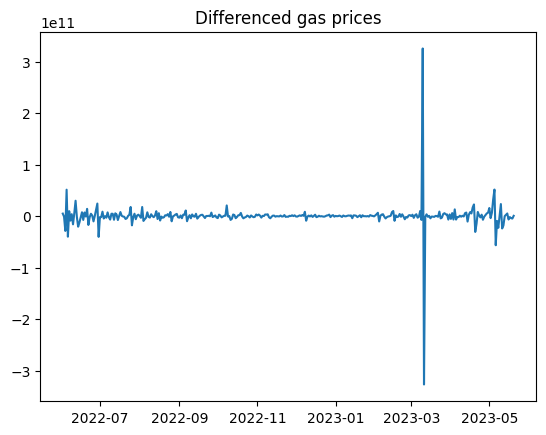

In [61]:
# Perform Augmented Dickey-Fuller test on the differenced data
adf_test = adfuller(daily_gas_price_df['gas_price_diff'])

# Extract p-value from the test results
print(f'p-value: {adf_test[1]}')

# If p-value < 0.05, we can reject the null hypothesis and say that the data is stationary
# Plot the differenced data
plt.plot(daily_gas_price_df['gas_price_diff'])
plt.title('Differenced gas prices')
plt.show()


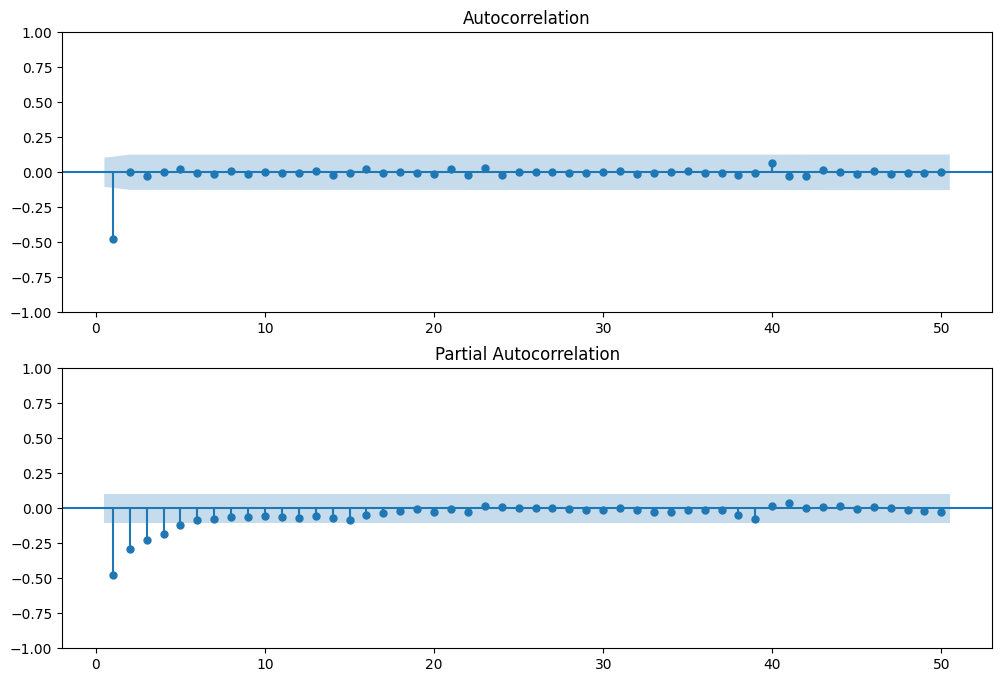

In [62]:
# Define the size of the plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))

# Plot the ACF on ax1
plot_acf(daily_gas_price_df['gas_price_diff'], lags=50, zero=False, ax=ax1)

# Plot the PACF on ax2
plot_pacf(daily_gas_price_df['gas_price_diff'], lags=50, zero=False, ax=ax2)

# Show the plots
plt.show()

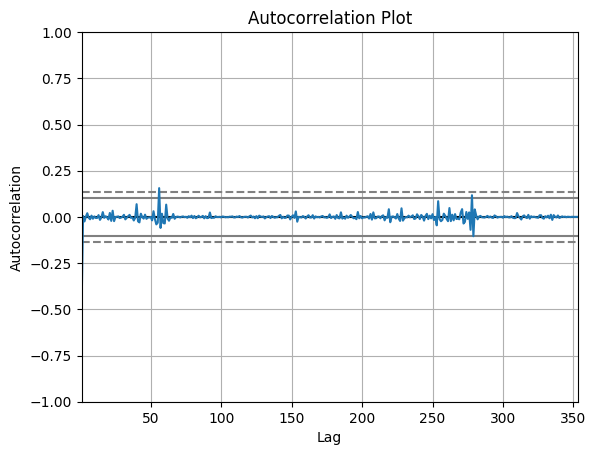

<Figure size 640x480 with 0 Axes>

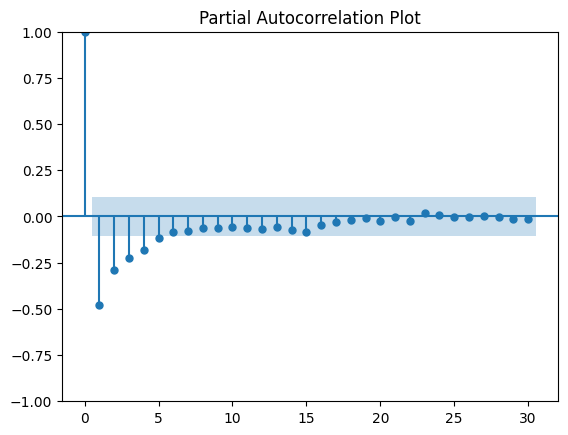

In [63]:
# Autocorrelation plot
plt.figure()
pd.plotting.autocorrelation_plot(daily_gas_price_df['gas_price_diff'])
plt.title('Autocorrelation Plot')

# Partial Autocorrelation plot
plt.figure()
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(daily_gas_price_df['gas_price_diff'], lags=30,)
plt.title('Partial Autocorrelation Plot')
plt.show()

### Step 9: Fit the ARIMA Model

In this step, we will fit an ARIMA model to our dataset. ARIMA stands for AutoRegressive Integrated Moving Average. It is a class of model that captures a suite of different standard temporal structures in time series data.

The parameters of the ARIMA model:

* p: The number of lag observations in the model; also known as the lag order.
* d: The number of times that the raw observations are differenced; also known as the degree of differencing.
* q: The size of the moving average window; also known as the order of moving average.

For each combination of parameters p, d, and q, we'll choose the model with the lowest Akaike Information Criterion (AIC). The AIC is a measure of the quality of each model, relative to each of the other models. The lower AIC score is better

In [64]:
#Split data on train and test
split_point = int(len(daily_gas_price_df) * 0.8)

In [65]:
# Define train and test
train = daily_gas_price_df.iloc[:split_point]
test = daily_gas_price_df.iloc[split_point:]

In [66]:
train.head()

,timestamp,gas_price,gas_price_diff
timestamp,,,
2022-06-02,2022-06-02 23:31:10,52125073354,4.793936e+09
2022-06-03,2022-06-03 23:04:29,50925847852,-1.199226e+09
2022-06-04,2022-06-04 23:02:52,22076581780,-2.884927e+10
2022-06-05,2022-06-05 23:50:57,73286894729,5.121031e+10
2022-06-06,2022-06-06 23:31:13,33258057747,-4.002884e+10


In [67]:
test.tail()

,timestamp,gas_price,gas_price_diff
timestamp,,,
2023-05-16,2023-05-16 23:07:59,39454459644,-6.646110e+09
2023-05-17,2023-05-17 23:28:47,37511919821,-1.942540e+09
2023-05-18,2023-05-18 23:43:11,33310207590,-4.201712e+09
2023-05-19,2023-05-19 23:59:23,28548516604,-4.761691e+09
2023-05-20,2023-05-20 15:50:35,29012598570,4.640820e+08


In [71]:
# Define the p, d and q parameters to take any value between 0 and 3 
p = d = q = range(0, 3)

# Generate all different combinations of p, d and q triplets
# So we can iterate over these combinations and find the best parameters for our model
pdq = list(itertools.product(p, d, q))

# Create an empty dictionary to store the evaluation metrics of the models we'll try
# Create dictionary for the performance of each model
models_metrics = {}

# Loop over all the combinations of p, d, q
for param in pdq:
    try:
        # Fit the ARIMA model with the current combination of parameters
        model = ARIMA(train['gas_price'], order=param)
        model_fit = model.fit()

        # Get the Akaike Information Criterion (AIC) of the model
        # The AIC is a measure of the quality of the model: the lower, the better
        models_metrics[param] = model_fit.aic
    except:
        # In case the model cannot be fit with the current combination of parameters, we continue to the next one
        continue

# Print the best model
best_model = min(models_metrics, key=models_metrics.get)
print('The best ARIMA model is {}'.format(best_model))


/Users/lexx/opt/anaconda3/envs/blockchain/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lexx/opt/anaconda3/envs/blockchain/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/lexx/opt/anaconda3/envs/blockchain/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/lexx/opt/anaconda3/envs/blockchain/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  

The best ARIMA model is (0, 2, 2)


In [72]:
# Print all model metrics 14100.686149823596
for model, metric in models_metrics.items():
    print(f'Model {model} has AIC: {metric}')
    
# Print the best model
best_model = min(models_metrics, key=models_metrics.get)
print(f'\nThe best ARIMA model is {best_model} with AIC: {models_metrics[best_model]}')

Model (0, 0, 0) has AIC: 15540.422116413596
Model (0, 0, 1) has AIC: 14216.330012863262
Model (0, 0, 2) has AIC: 14204.891667647946
Model (0, 1, 0) has AIC: 941800.6633042472
Model (0, 1, 1) has AIC: 14140.40911248892
Model (0, 1, 2) has AIC: 14142.408696138464
Model (0, 2, 0) has AIC: 9.993374545852183e+26
Model (0, 2, 1) has AIC: 14106.365826017689
Model (0, 2, 2) has AIC: 14100.686149823596
Model (1, 0, 0) has AIC: 14200.680764632023
Model (1, 0, 1) has AIC: 14195.171855605986
Model (1, 0, 2) has AIC: 14197.172819265537
Model (1, 1, 0) has AIC: 14141.809234391894
Model (1, 1, 1) has AIC: 14142.407644503299
Model (1, 1, 2) has AIC: 14144.338779633876
Model (1, 2, 0) has AIC: 14124.50590862587
Model (1, 2, 1) has AIC: 14101.426493889336
Model (1, 2, 2) has AIC: 14102.57387960076
Model (2, 0, 0) has AIC: 14195.269154974736
Model (2, 0, 1) has AIC: 14197.270115262145
Model (2, 0, 2) has AIC: 14198.176456926438
Model (2, 1, 0) has AIC: 14143.257326009076
Model (2, 1, 1) has AIC: 14143.64

### Step10: Plot Residuals.
After selecting the best model parameters based on the AIC, we will fit the model with these parameters and examine the residuals. The residuals of the model are important, they can give us insight into how well our model is performing. 
We'll plot the residuals over time and their density plot. The first plot gives us an idea of how the residuals are distributed over time. The second one, the density plot, should ideally follow a normal distribution centered around zero.

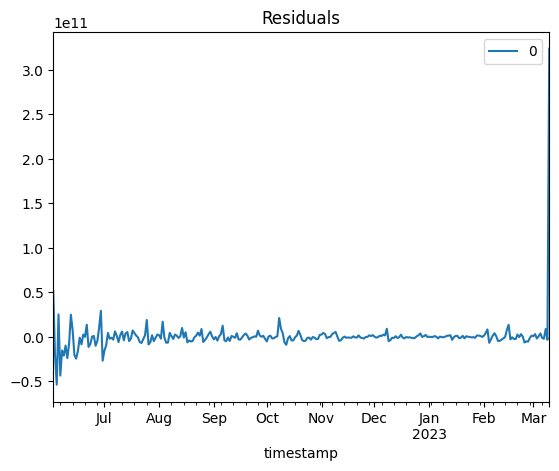

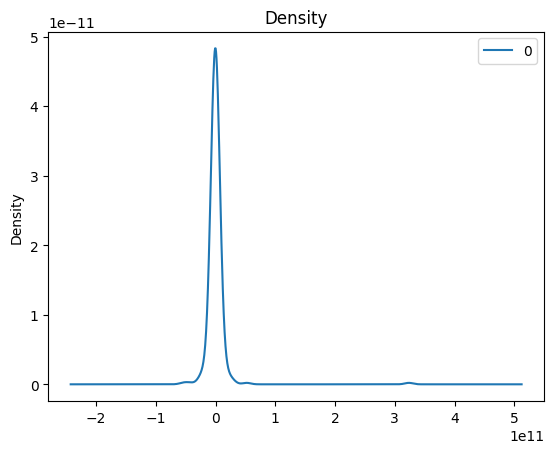

                  0
count  2.820000e+02
mean   5.765487e+08
std    2.093654e+10
min   -5.385868e+10
25%   -2.546745e+09
50%   -3.434607e+08
75%    1.438662e+09
max    3.235802e+11


In [73]:
# Fit the model with the best parameters
best_p, best_d, best_q = best_model
model = ARIMA(train['gas_price'], order=(best_p, best_d, best_q))
best_model_fit = model.fit()

# Plot residuals
residuals = pd.DataFrame(best_model_fit.resid)
residuals.plot(title = "Residuals")
plt.show()

# Plot density of residuals
residuals.plot(kind='kde',
              title ="Density")
plt.show()

# Print the statistics of the residuals
print(residuals.describe())

In [74]:
# Print the best model's summary
print(best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              gas_price   No. Observations:                  282
Model:                 ARIMA(0, 2, 2)   Log Likelihood               -7047.343
Date:                Wed, 24 May 2023   AIC                          14100.686
Time:                        23:07:38   BIC                          14111.591
Sample:                    06-02-2022   HQIC                         14105.060
                         - 03-10-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.4755      0.308     -4.798      0.000      -2.078      -0.873
ma.L2          0.4999      0.253      1.974      0.048       0.004       0.996
sigma2      4.329e+20        nan        nan        n

### Step 11: Check Autocorrelation of Residuals
Plot the ACF and PACF of the residuals. If the residuals are uncorrelated, most of the spikes in the ACF and PACF within the blue shaded area would not be significantly different from zero, and there's no pattern to the points. If not, the model might need to be refined.

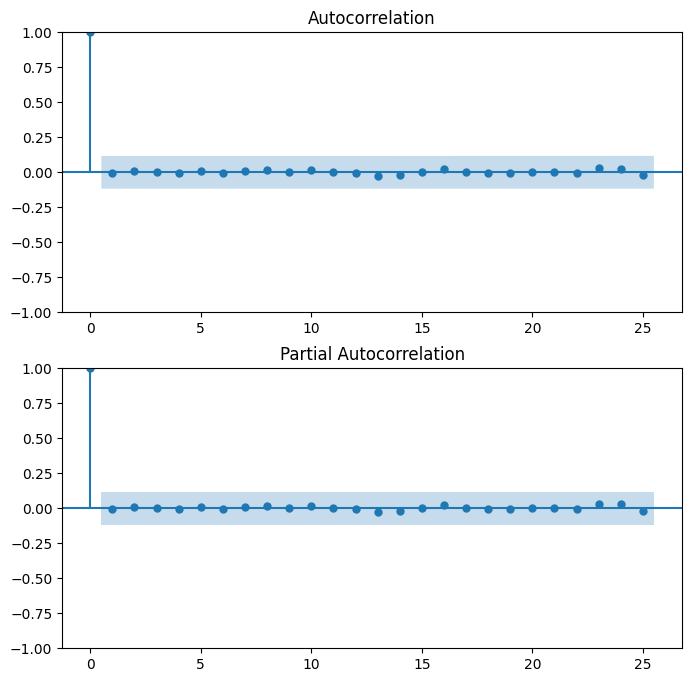

In [75]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))

# Plot the ACF of residuals
plot_acf(residuals, ax=ax1)

# Plot the PACF of residuals
plot_pacf(residuals, ax=ax2)

plt.show()


#### Step 13: Rolling Window Forecast with 7-day window and 1-day forecast
We are using rolling window of the last 7 days' data to make a prediction for the next day. The rolling window moves one day at a time through the data, so we have a prediction for each day from the 8th day onwards based on the previous 7 days' data.

In [76]:
# Define a function for the rolling forecast using ARIMA model
def arima_rolling_forecast(train, order, window_size=7):
    """
    Perform a rolling forecast using an ARIMA model with specified window size.

    Parameters:
    train (array-like): The training data.
    order (tuple): The order of the ARIMA model.
    window_size (int): The size of the rolling window.

    Returns:
    predictions (list): The forecasts for the test data.
    """
    predictions = []

    for i in range(0, len(train) - window_size):
        # Fit the ARIMA model on a window of data and make a one-step forecast
        window_data = train[i: i + window_size]
        model = ARIMA(window_data, order=order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        # Add the forecast to the list of predictions
        predictions.append(yhat)

    return predictions


In [77]:
# Set the best order from the previous step
order = (best_p, best_d, best_q)


In [78]:
# Use the function to forecast the test data
rolling_forecast = arima_rolling_forecast(daily_gas_price_df['gas_price'].values, order, window_size=7)

# Add the rolling forecast to the DataFrame
daily_gas_price_df['rolling_forecast'] = None
daily_gas_price_df.loc[daily_gas_price_df.index[7:7+len(rolling_forecast)], 'rolling_forecast'] = rolling_forecast

/Users/lexx/opt/anaconda3/envs/blockchain/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/lexx/opt/anaconda3/envs/blockchain/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lexx/opt/anaconda3/envs/blockchain/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lexx/opt/anaconda3/envs/blockchain/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. C

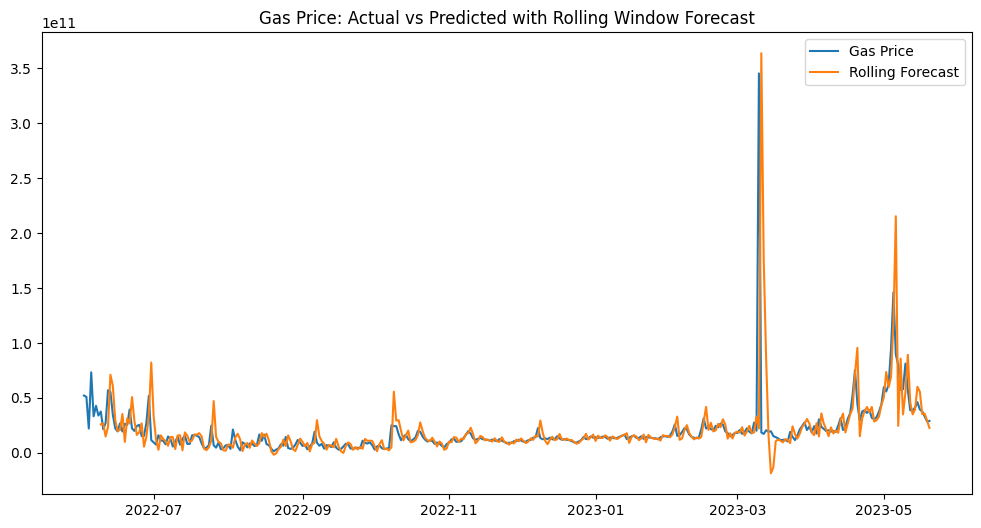

In [79]:
plt.figure(figsize=(12,6))
plt.plot(daily_gas_price_df.index, daily_gas_price_df['gas_price'], label='Gas Price')
plt.plot(daily_gas_price_df.index, daily_gas_price_df['rolling_forecast'], label='Rolling Forecast')
plt.legend(loc='best')
plt.title('Gas Price: Actual vs Predicted with Rolling Window Forecast')
plt.show()

In [80]:
daily_gas_price_df.head(40)


,timestamp,gas_price,gas_price_diff,rolling_forecast
timestamp,,,,
2022-06-02,2022-06-02 23:31:10,52125073354,4.793936e+09,None
2022-06-03,2022-06-03 23:04:29,50925847852,-1.199226e+09,None
2022-06-04,2022-06-04 23:02:52,22076581780,-2.884927e+10,None
2022-06-05,2022-06-05 23:50:57,73286894729,5.121031e+10,None
2022-06-06,2022-06-06 23:31:13,33258057747,-4.002884e+10,None
2022-06-07,2022-06-07 23:06:10,42772752073,9.514694e+09,None
2022-06-08,2022-06-08 23:51:13,33950590546,-8.822162e+09,None
2022-06-09,2022-06-09 23:38:12,37571748480,3.621158e+09,25916648638.250771
2022-06-10,2022-06-10 23:30:45,21524372904,-1.604738e+10,26693623394.585194


In [81]:
# Calculate the errors
mae = mean_absolute_error(daily_gas_price_df['gas_price'][len(train):],
                          daily_gas_price_df['rolling_forecast'][len(train):])

mape = mean_absolute_percentage_error(daily_gas_price_df['gas_price'][len(train):],
                                      daily_gas_price_df['rolling_forecast'][len(train):])

mse = mean_squared_error(daily_gas_price_df['gas_price'][len(train):], 
                         daily_gas_price_df['rolling_forecast'][len(train):])

rmse = np.sqrt(mse)

# Print the errors
print(f'Mean Absolute Error: {mae}')
print(f'Mean Absolute Percentage Error: {mape}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')

Mean Absolute Error: 18863016791.490963
Mean Absolute Percentage Error: 0.7325675319392314
Mean Squared Error: 2.5339997263018034e+21
Root Mean Squared Error: 50338849076.0546


### Step 14: Evaluate Model's Performance

In [82]:

# Define a function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    """
    Calculate Mean Absolute Percentage Error (MAPE).

    Parameters:
    y_true (array-like): The actual values.
    y_pred (array-like): The predicted values.

    Returns:
    mape (float): The MAPE.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Slice test['gas_price'].values and rolling_forecast to have the same size
size = min(len(test['gas_price'].values), len(rolling_forecast))

# Calculate MAPE for the rolling forecast
mape = mean_absolute_percentage_error(test['gas_price'].values[:size], rolling_forecast[:size])
print('The Mean Absolute Percentage Error for the rolling forecast is: ', mape)

The Mean Absolute Percentage Error for the rolling forecast is:  79.50590858214002


In [83]:
# Save the model to a file
dump(model_fit, 'saved_models/Alex_ARIMA_model.joblib') 

['saved_models/Alex_ARIMA_model.joblib']

### Step 16: Load the Model and Make Predictions

In [84]:
# Load the model from the file
model = load('saved_models/Alex_ARIMA_model.joblib')

# Make a prediction
yhat = model.forecast()[0]

print(f'The forecasted Ethereum gas price is: {yhat}')

The forecasted Ethereum gas price is: 164819370180.72156


In [87]:
# Avarage model 
avg_model = train['gas_price'].mean()
print(avg_model)

15335184722.127659


In [88]:
preds_df = pd.DataFrame({"test":test['gas_price'], "avg_model_preds":[avg_model]*len(test)})

In [89]:
def RMSE(actual, pred):
    return (sum((actual - pred)**2)/ len(actual))**0.5

In [90]:
RMSE(preds_df['test'], preds_df['avg_model_preds'])

30346487158.91857